In [1]:
#  !pip install torch

In [2]:
# !pip install --upgrade typing_extensions

In [3]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

drive.mount('/content/drive')
save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


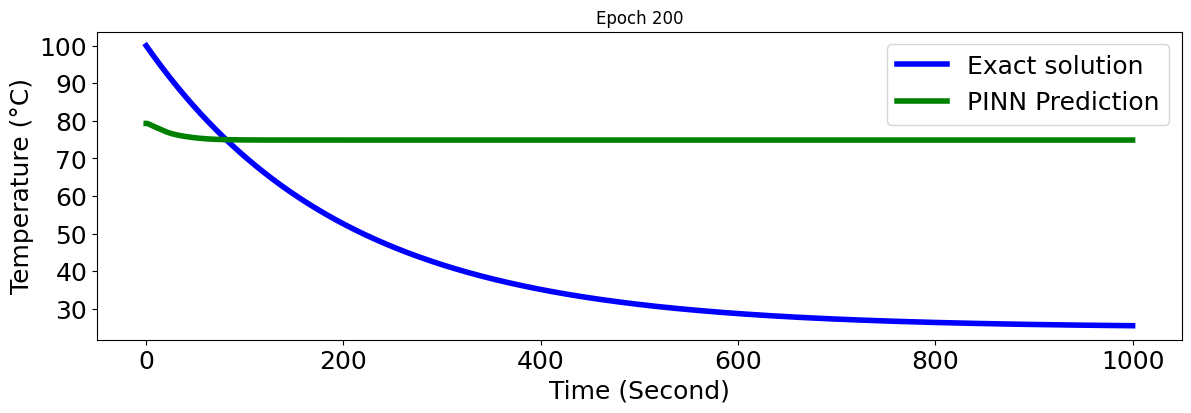

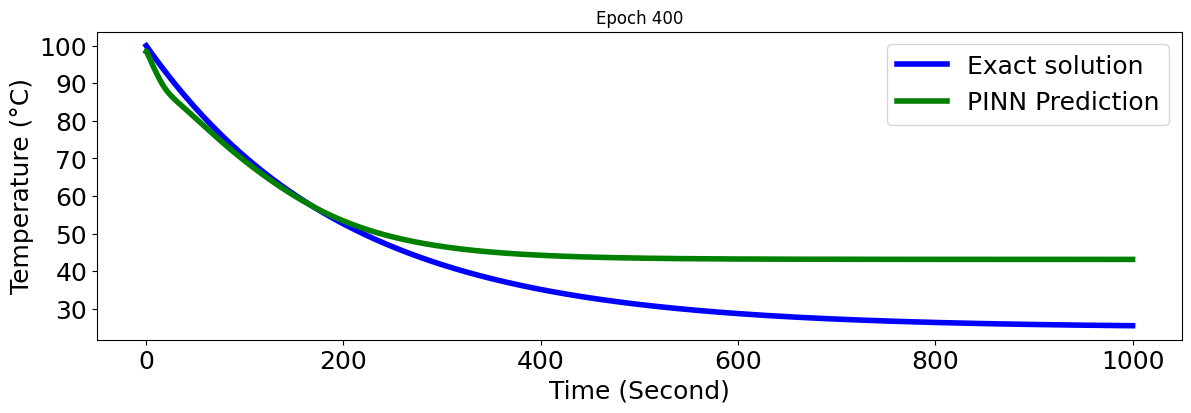

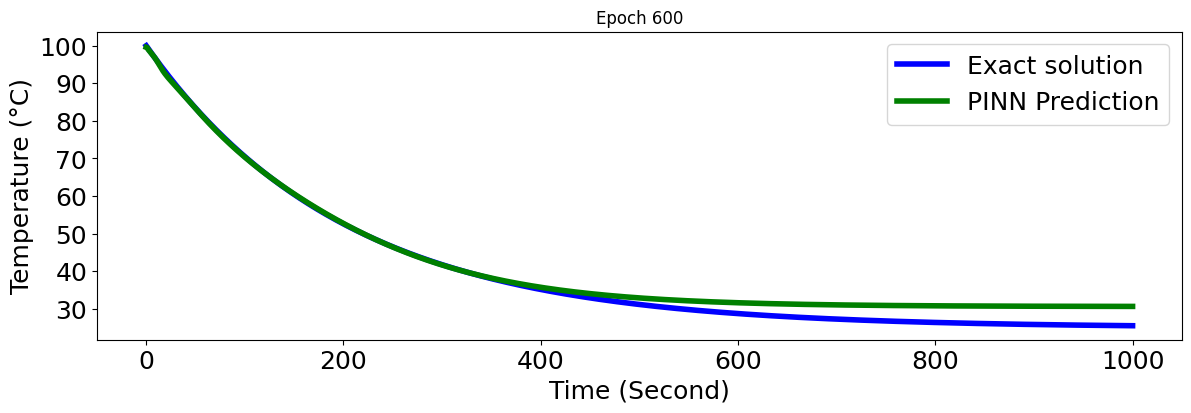

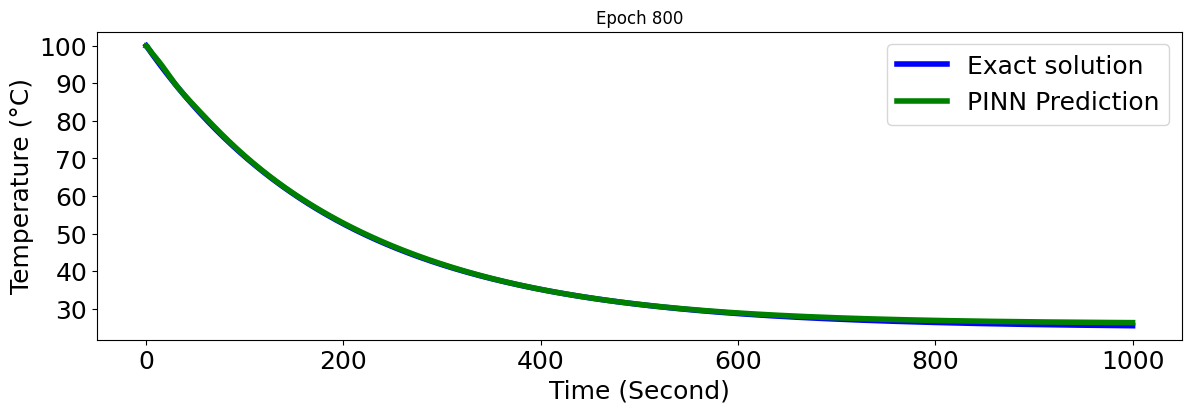

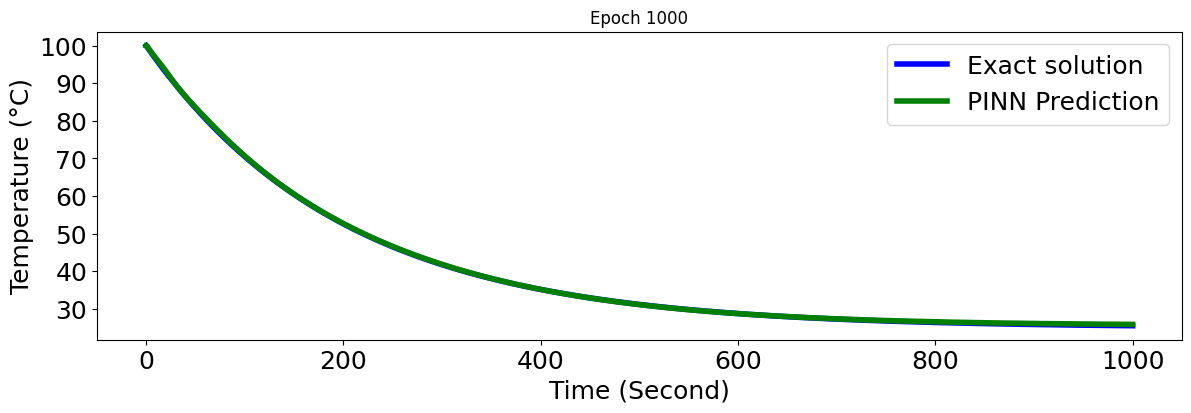

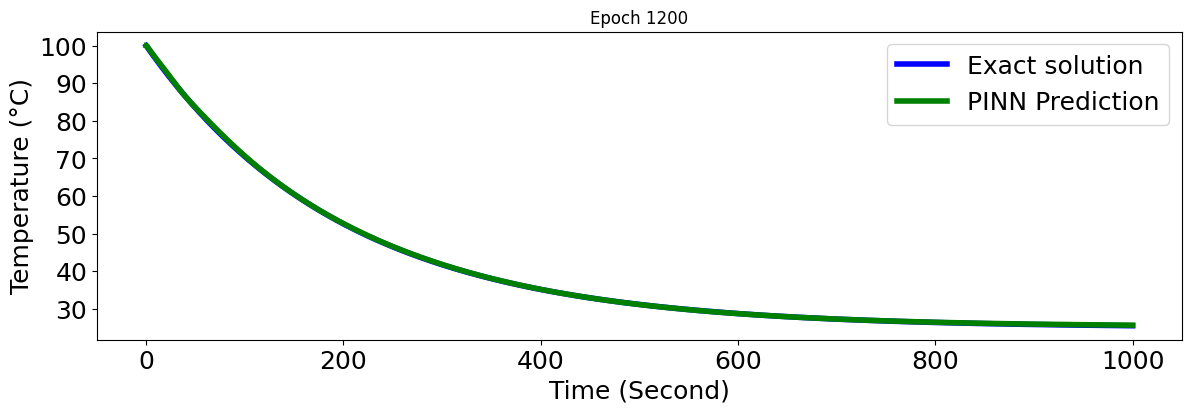

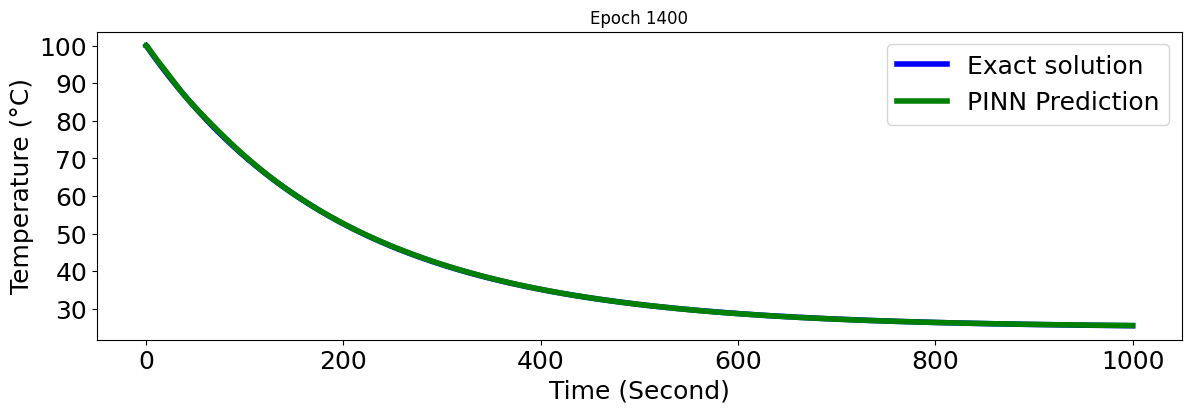

In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
torch.manual_seed(123)
save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)

# ====================
# Define Functions
# ====================
def calculate_temperature(T_0, T_env, r, time):
    """Computes the exact solution to Newton's Law of Cooling."""
    return T_env + (T_0 - T_env) * torch.exp(-r * time)

def newtons_cooling_residual(t, model, k, T_env):
    """
    Compute the residual of Newton's Law of Cooling for PINN physics loss.
    """
    T_pred = model(t)
    dT_dt = torch.autograd.grad(
        T_pred, t, grad_outputs=torch.ones_like(T_pred),
        create_graph=True
    )[0]

    residual = dT_dt + k * (T_pred - T_env)
    return residual


class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size , hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size )
        self.activation = torch.tanh

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x



# ====================
# Define Model & Optimizer
# ====================
input_size = 1
hidden_size = 50
output_size = 1
model = SimpleNN()
optimizer = optim.Adam(model.parameters(), lr=1e-2)


scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[ 400,800], gamma=0.40)
# ====================
# Constants
# ====================
T_env = 25  # Environment temperature
T_0 = 100  # Initial temperature at t = 0
r = 0.005   # Cooling rate

# Define boundary point (Initial condition at t=0)
time_inital = torch.tensor([[0.0]], requires_grad=True)
time_physics = torch.cat([ torch.linspace(0, 1000,1000)]).view(-1,1).requires_grad_(True) # collocation points

# Generate exact solution for comparison
time_test = torch.linspace(0, 1000, 1000).view(-1,1)
T_exact = calculate_temperature(T_0, T_env, r, time_test)




# ====================
# Train the PINN
# ====================
losses_initial, losses_boundary, losses_pde, losses_total, l2_errors = [], [], [], [], []
for epoch in range(1400):
    optimizer.zero_grad()

    # Initial Condition Loss (T(0) = T_0,at t=0)
    u_initial = model(time_inital)
    loss_initial = (torch.squeeze(u_initial) - T_0) ** 2
    # ODE Physics Loss
    residual = newtons_cooling_residual(time_physics, model, r, T_env)
    loss_pde = torch.mean(residual**2)

    lambda1= 6e-2
    lambda2 = 10e-1
    # Compute total loss
    loss_total = lambda1* loss_initial  + lambda2 * loss_pde

    loss_total.backward()

    optimizer.step()
    scheduler.step()


    # Store loss values
    losses_initial.append(loss_initial.item())
    # losses_boundary.append(loss_boundary.item())
    losses_pde.append(loss_pde.item())
    losses_total.append(loss_total.item())

    # Compute L2 error
    T_pred = model(time_test).detach()
    l2_error = torch.norm(T_pred  - T_exact, p=2) / torch.norm(T_exact, p=2)
    l2_errors.append(l2_error.item())

    # Save model & plot every 200 epochs
    if (epoch + 1) % 200 == 0:

        # Save model
        torch.save(model.state_dict(), f'{save_dir}/trained_model_epoch_{epoch+1}.pth')

        # Plot results
        plt.figure(figsize=(14, 4))
        plt.plot(time_test[:,0], T_exact[:,0], label="Exact solution", color='b',linewidth=4 )
        plt.plot(time_test[:,0], T_pred[:,0], label="PINN Prediction", color='g', linewidth=4)
        plt.xlabel('Time (Second)', fontsize=18)
        plt.ylabel('Temperature (°C)', fontsize=18)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=18)
        plt.title(f"Epoch {epoch+1}")
        plt.savefig(f'{save_dir}/PINN_prediction_epoch_{epoch+1}.png', dpi=400)
        plt.show()
        plt.close()


torch.save(model.state_dict(), f'{save_dir}/trained_model_final.pth')



with open(f'{save_dir}/losses_log_cooling.txt', 'w') as f:
    f.write("Total Loss\n")
    f.write("Epoch, Initial Loss, PDE Loss, Total Loss, L2 Error\n")
    for epoch in range(len(losses_total)):
        l2_error = l2_errors[epoch] if epoch < len(l2_errors) else "N/A"
        f.write(f"{epoch+1}, {losses_initial[epoch]}, {losses_pde[epoch]}, {losses_total[epoch]}, {l2_error}\n")



In [5]:
# # ====================
# # Part 6: Plot Losses
# # ====================
# plt.figure(figsize=(10, 5))
# plt.plot(losses_initial, label="Initial Loss", linestyle="-", color="b")
# plt.plot(losses_pde, label="PDE Loss", linestyle="-", color="g")
# plt.plot(losses_total, label="Total Loss", linestyle="-", color="k")

# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.yscale("log")
# plt.title("Loss Components Over Training")
# plt.legend()
# plt.grid(True)
# plt.savefig("loss_plot.png", dpi=300)
# plt.show()


In [6]:
# ====================
# Part 6: Compute L2 Error
# ====================
T_pred = model(time_test).detach()
l2_error = torch.norm(T_pred - T_exact, p=2) / torch.norm(T_exact, p=2)

print(f"L2 Error: {l2_error.item():.6f}")


L2 Error: 0.001735


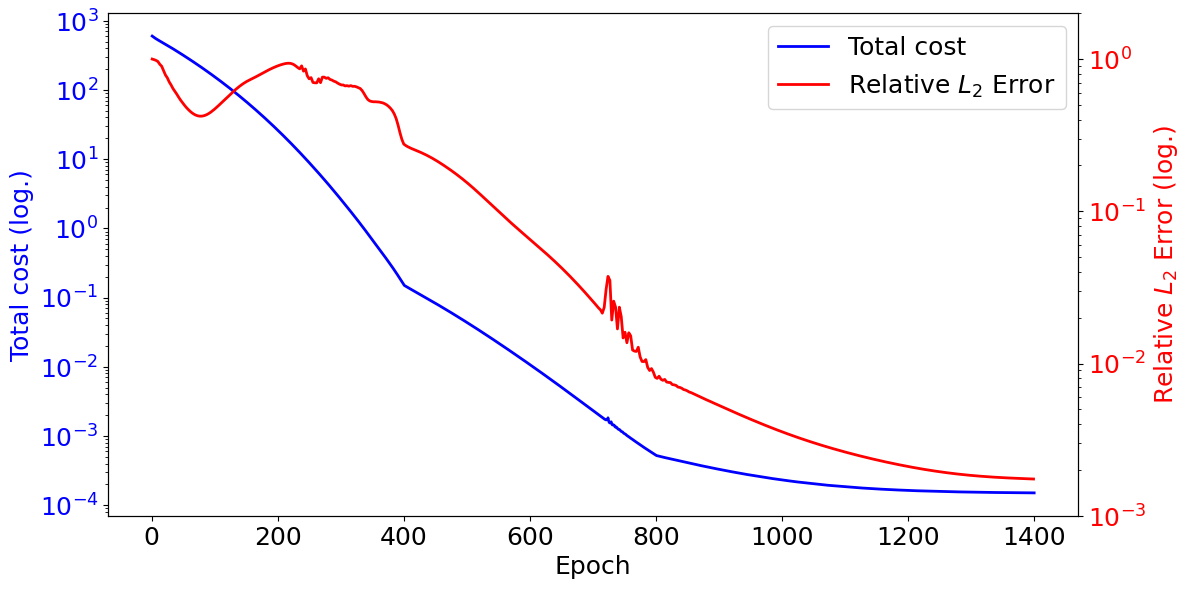

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os


save_dir = '/content/drive/My Drive/1DPINN_NEW'
os.makedirs(save_dir, exist_ok=True)


relative_L2_error = np.array(l2_errors) / np.max(l2_errors)


iterations = np.arange(1, len(losses_total) + 1)


iterations_sliced = iterations[::3]
relative_L2_error_sliced = relative_L2_error[::3]


min_len = min(len(iterations_sliced), len(relative_L2_error_sliced))
iterations_sliced = iterations_sliced[:min_len]
relative_L2_error_sliced = relative_L2_error_sliced[:min_len]

# PLot
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.set_xlabel('Epoch', fontsize=18)
ax1.set_ylabel('Total cost (log.)', color='blue', fontsize=18)
total_loss_plot, = ax1.plot(iterations, losses_total, label='Total cost', color='blue', linewidth=2, linestyle='solid')
ax1.set_yscale('log')
ax1.tick_params(axis='y', labelcolor='blue', labelsize=18)
ax1.tick_params(axis='x', labelsize=18)
ax2 = ax1.twinx()
ax2.set_ylabel('Relative $L_2$ Error (log.)', color='red', fontsize=18)


error_plot, = ax2.plot(iterations_sliced, relative_L2_error_sliced, label='Relative $L_2$ Error', linestyle='solid', color='red', linewidth=2)
ax2.set_yscale('log')
ax2.set_ylim(1e-3, 2)
ax2.tick_params(axis='y', labelcolor='red', labelsize=18)
plt.legend(handles=[total_loss_plot, error_plot], loc='upper right', fontsize=18)
fig.tight_layout()
save_path = os.path.join(save_dir, "loss_convergence_1D.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()


